In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [74]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [75]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

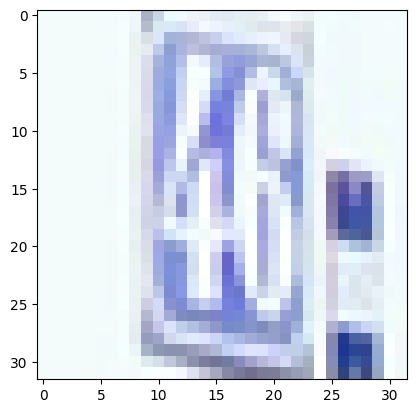

In [76]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

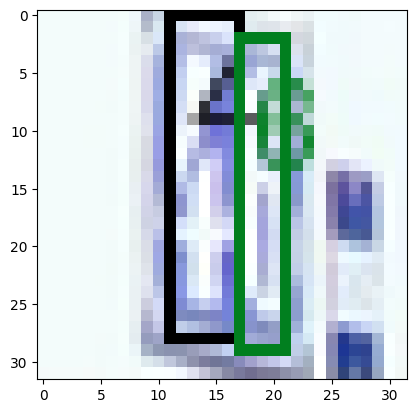

In [77]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [78]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [79]:
len(dataloader)

1

In [80]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [ ]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [ ]:
import json

In [97]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment2.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=100,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

In [98]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([8, 15]) torch.Size([8, 15])


RuntimeError: 

In [83]:
pred = model(batch["images"])
pred

[tensor([[[[ 5.5823e+00, -2.6199e+00,  1.8949e+00,  3.0887e+00, -5.2589e+00,
            -3.4561e+00,  8.7781e-01,  2.2489e+00,  3.7033e-01, -3.1632e+00,
            -3.4433e+00,  2.3431e-01, -2.7330e+00, -1.8185e-01, -1.4237e+00],
           [-2.7997e+00, -6.9775e+00,  1.0724e+00,  2.2807e-01, -6.4843e+00,
            -3.8240e+00, -1.6324e+00, -3.7564e+00, -4.7875e+00, -2.4117e+00,
            -3.4526e+00,  8.7442e-02,  2.8034e+00, -7.9440e+00, -1.1564e-01],
           [ 5.5694e+00, -2.5830e+00,  1.8965e+00,  3.1062e+00, -5.2213e+00,
            -3.4632e+00,  9.1738e-01,  2.2247e+00,  3.4560e-01, -3.1445e+00,
            -3.4346e+00,  1.9383e-01, -2.7772e+00, -1.6003e-01, -1.4663e+00],
           [-1.2174e+00, -5.0398e+00,  1.0036e+00,  9.9833e-01, -6.0829e+00,
            -2.8355e+00, -1.2589e+00, -2.1158e+00, -2.8860e+00, -2.0658e+00,
            -2.0020e+00,  2.3954e-01,  1.5950e+00, -5.5108e+00,  2.5755e-01]],
 
          [[ 6.8279e+00, -3.0934e+00,  2.2626e+00,  3.8127e+00, -6.34

In [93]:
i = 1

In [94]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.5912, 0.5360, 0.1666, 0.7649],
          [0.4401, 0.5000, 0.2024, 0.7529]]),
  'confidence': tensor([1.0000, 0.9955]),
  'labels': tensor([1, 7]),
  'scores': tensor([1.0000, 1.0000])},
 {'bboxes': tensor([[0.4515, 0.4564, 0.1942, 0.8494],
          [0.6071, 0.5000, 0.1501, 0.8899]]),
  'confidence': tensor([1.0000, 0.9955]),
  'labels': tensor([4, 6]),
  'scores': tensor([1.0000, 1.0000])}]

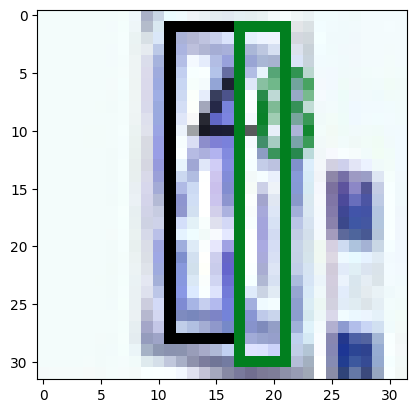

In [95]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

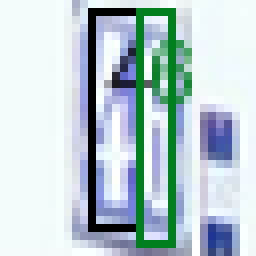

In [96]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [88]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 1.0,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}